# Deep RL for time series playing idealized trading games

Applying the methodology from the Paper *Deep reinforcement learning for time series: playing idealized trading games* to the data set of this project.

First, here is the implementation from the orginal paper:

In [1]:
import random
import torch as T
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import pickle
import os

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

episode  0 score 16.49 average score 16.49 epsilon 0.99
episode  1 score -89.21 average score -36.36 epsilon 0.98
episode  2 score -186.44 average score -86.39 epsilon 0.96
episode  3 score 88.45 average score -42.68 epsilon 0.95
episode  4 score -408.43 average score -115.83 epsilon 0.94
episode  5 score 223.50 average score -59.27 epsilon 0.92
episode  6 score -65.33 average score -60.14 epsilon 0.91
episode  7 score 27.16 average score -49.23 epsilon 0.90
episode  8 score -184.16 average score -64.22 epsilon 0.88
episode  9 score -222.54 average score -80.05 epsilon 0.87


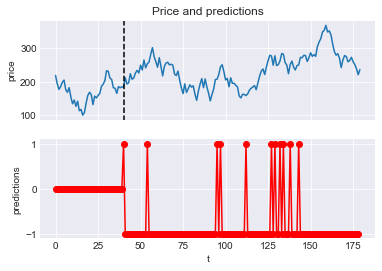

In [2]:
class Sampler:

	def load_db(self, fld):

		self.db = pickle.load(open(os.path.join(fld, 'db.pickle'),'rb'))
		param = json.load(open(os.path.join(fld, 'param.json'),'rb'))
		self.i_db = 0
		self.n_db = param['n_episodes']
		self.sample = self.__sample_db
		for attr in param:
			if hasattr(self, attr):
				setattr(self, attr, param[attr])
		self.title = 'DB_'+param['title']


	def build_db(self, n_episodes, fld):
		db = []
		for i in range(n_episodes):
			prices, title = self.sample()
			db.append((prices, '[%i]_'%i+title))
		os.makedirs(fld)	# don't overwrite existing fld
		pickle.dump(db, open(os.path.join(fld, 'db.pickle'),'wb'))
		param = {'n_episodes':n_episodes}
		for k in self.attrs:
			param[k] = getattr(self, k)
		json.dump(param, open(os.path.join(fld, 'param.json'),'w'))


	def __sample_db(self):
		prices, title = self.db[self.i_db]
		self.i_db += 1
		if self.i_db == self.n_db:
			self.i_db = 0
		return prices, title


class PairSampler(Sampler):

	def __init__(self, game,
		window_episode=None, forecast_horizon_range=None, max_change_perc=10., noise_level=10., n_section=1,
		fld=None, windows_transform=[]):

		self.window_episode = window_episode
		self.forecast_horizon_range = forecast_horizon_range
		self.max_change_perc = max_change_perc
		self.noise_level = noise_level
		self.n_section = n_section
		self.windows_transform = windows_transform
		self.n_var = 2 + len(self.windows_transform) # price, signal

		self.attrs = ['title', 'window_episode', 'forecast_horizon_range', 
			'max_change_perc', 'noise_level', 'n_section', 'n_var']
		param_str = str((self.noise_level, self.forecast_horizon_range, self.n_section, self.windows_transform))

		if game == 'load':
			self.load_db(fld)
		elif game in ['randwalk','randjump']:
			self.__rand = getattr(self, '_PairSampler__'+game)
			self.sample = self.__sample
			self.title = game + param_str
		else:
			raise ValueError


	def __randwalk(self, l):
		change = (np.random.random(l + self.forecast_horizon_range[1]) - 0.5) * 2 * self.max_change_perc/100
		forecast_horizon = random.randrange(self.forecast_horizon_range[0], self.forecast_horizon_range[1])
		return change[:l], change[forecast_horizon: forecast_horizon + l], forecast_horizon


	def __randjump(self, l):
		change = [0.] * (l + self.forecast_horizon_range[1])
		n_jump = random.randrange(15,30)
		for i in range(n_jump):
			t = random.randrange(len(change))
			change[t] = (np.random.random() - 0.5) * 2 * self.max_change_perc/100
		forecast_horizon = random.randrange(self.forecast_horizon_range[0], self.forecast_horizon_range[1])
		return change[:l], change[forecast_horizon: forecast_horizon + l], forecast_horizon



	def __sample(self):

		L = self.window_episode
		if bool(self.windows_transform):
			L += max(self.windows_transform)
		l0 = L/self.n_section
		l1 = L

		d_price = []
		d_signal = []
		forecast_horizon = []

		for i in range(self.n_section):
			if i == self.n_section - 1:
				l = l1
			else:
				l = l0
				l1 -= l0
			d_price_i, d_signal_i, horizon_i = self.__rand(l)
			d_price = np.append(d_price, d_price_i)
			d_signal = np.append(d_signal, d_signal_i)
			forecast_horizon.append(horizon_i)

		price = 100. * (1. + np.cumsum(d_price))
		signal = 100. * (1. + np.cumsum(d_signal)) + \
				np.random.random(len(price)) * self.noise_level

		price += (100 - min(price))
		signal += (100 - min(signal))

		inputs = [price[-self.window_episode:], signal[-self.window_episode:]]
		for w in self.windows_transform:
			inputs.append(signal[-self.window_episode - w: -w])

		return np.array(inputs).T, 'forecast_horizon='+str(forecast_horizon)


def get_PairSampleDf(size_time_series):
	fhr = (10,30)
	n_section = 1
	max_change_perc = 30.
	noise_level = 5
	game = 'randwalk'
	windows_transform = []

	sampler = PairSampler(game, window_episode=size_time_series, forecast_horizon_range=fhr, 
		n_section=n_section, noise_level=noise_level, max_change_perc=max_change_perc, windows_transform=windows_transform)   
    
	x = sampler.sample()[0]  
        
	price = x[:, 0]
	signal = x[:, 1]    
	df = pd.DataFrame({'y': price, 'signal': signal})
    
	return df


class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, 
            n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
            max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=64, fc2_dims=32)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1
        
    def get_q_valid(self, q, valid_actions):
        q_valid = [np.nan] * len(q)
        for action in valid_actions:
            q_valid[action] = q[action]
        
        return q_valid

    def choose_action(self, observation, valid_actions):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation], dtype=T.float32).to(self.Q_eval.device)
            q = self.Q_eval.forward(state)
            q = q.detach().numpy().squeeze()
            q = self.get_q_valid(q, valid_actions)
            action = np.nanargmax(q)
        else:
            action = np.random.choice(valid_actions)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next,dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                       else self.eps_min



class Environment():
    
    
    def __init__(self, n_games, window_size_observation, size_time_series):
        self.name = 'gao'
        self.n_games = n_games
        self.window_size_observation = window_size_observation 
        self.size_time_series = size_time_series
        self.current_game = 0
        self.t_current = 0
        self.empty = True
        self.open_cost = 0
        
        self.list_of_games = self.get_list_of_games()
        self.t_max = self.size_time_series - self.window_size_observation - 1

      
    def get_status_emtpy(self):
        return self.empty

    
    def get_current_df(self):
        return self.list_of_games[self.current_game]

        
    def get_list_of_games(self):
        list_of_games = []
        
        for i in range(self.n_games):
            list_of_games.append(get_PairSampleDf(size_time_series))
                   
        return list_of_games
    
    
    def reset(self):
        if self.current_game == self.n_games - 1:
            self.current_game = 0
        else:
            self.current_game += 1
            
        self.t_current = 0
        
        observation = self.get_observation()
        
        return observation
        
    
    def step(self, action):
        
        done = False
        if action == 0:		# wait/close
            reward = 0.
            self.empty = True
        elif action == 1:	# open
            reward = self.get_reward_noncash()
            self.empty = False
        elif action == 2:	# keep
            reward = self.get_reward_noncash()
        else:
            raise ValueError('no valid action: ' + str(action))
        
        self.t_current += 1
        #return self.get_state(), reward, self.t == self.t_max, self.get_valid_actions()
        
        
        done = self.t_current == self.t_max
        observation = self.get_observation()
        info = self.get_valid_actions()
        
        return observation, reward, done, info
 
    
    def get_reward_noncash(self):
        df_current = self.list_of_games[self.current_game]
               
        t_1 = self.t_current + self.window_size_observation + 1
        t = self.t_current + self.window_size_observation 
        
        price_t_1 = df_current.iloc[t_1, 0]
        price_t = df_current.iloc[t, 0]
        
        reward = price_t_1 - price_t
        
        if self.empty:
            reward -= self.open_cost
        
        return reward 
       
    
    
    def get_observation(self):
        df_current = self.list_of_games[self.current_game]
        
        observation = df_current.iloc[self.t_current:(self.t_current + self.window_size_observation), :]
        
        return observation
    
    
    def get_valid_actions(self):
        if self.empty:
            return [0, 1]	# wait, open
        else:
            return [0, 2]	# close, keep 
    

  
        
    def render(self):
        pass

    

def get_prediction(action, empty_status):
    # Determines prediction on a given empty_status and action
    # if empty, i. e. no stock is in depot, if action == 1 (buying) you bet on rising price
    # if not empty, i. e. stock is in depot, if action == 0 (selling) you bet on falling price
    
    if empty_status:
        if action == 1:
            return 1
        return -1
    else:
        if action == 0:
            return -1
        return 1
    
    
    
if __name__ == '__main__':
    n_games = 10
    window_size_observation = 40
    size_time_series = 180
    
    
    agent = Agent(gamma=0.8, epsilon=1, batch_size=64, n_actions=3, eps_end=0.01, 
                  input_dims=[window_size_observation], lr=0.001, eps_dec=1e-4)
    
    env = Environment(n_games, window_size_observation, size_time_series)
    
    scores, eps_history = [], []

    for i in range(n_games):
        score = 0
        done = False
        
        observation = env.reset()
        valid_actions = [0, 1]
        
        # take only signal as observation for now: 
        observation = observation.iloc[:, 1:].values.squeeze()
        
        while not done:
            action = agent.choose_action(observation, valid_actions)
            observation_, reward, done, valid_actions = env.step(action)
            
                
            # take only signal as observation for now: 
            observation_ = observation_.iloc[:, 1:].values.squeeze()
            
            score += reward
            agent.store_transition(observation, action, reward, 
                                    observation_, done)
            agent.learn()
            observation = observation_
        
        scores.append(score)
        eps_history.append(agent.epsilon)

        avg_score = np.mean(scores[-100:])

        print('episode ', i, 'score %.2f' % score,
                'average score %.2f' % avg_score,
                'epsilon %.2f' % agent.epsilon)
            
        
        
# =============================================================================
#     # Evaluation 
# =============================================================================
    n_games = 1
    env = Environment(n_games, window_size_observation, size_time_series)
    agent.epsilon = 0
    
    actions, empty_status, rewards = [], [], []

    for i in range(n_games):
        score = 0
        done = False
        
        observation = env.reset()
        valid_actions = [0, 1]
        
        # take only signal as observation for now: 
        observation = observation.iloc[:, 1:].values.squeeze()
        
        while not done:
            action = agent.choose_action(observation, valid_actions)
            observation_, reward, done, valid_actions = env.step(action)
            
                
            # take only signal as observation for now: 
            observation_ = observation_.iloc[:, 1:].values.squeeze()
            
            score += reward
            observation = observation_
            
            
            empty_status.append(env.get_status_emtpy())
            actions.append(action)
            rewards.append(reward)
            

    
        df = env.get_current_df()
        predictions = [get_prediction(action, empty_status) for action, empty in zip(actions, empty_status)]
        
        predictions = [0 for i in range(window_size_observation)] + predictions
        rewards = [0 for i in range(window_size_observation)] + rewards
        actions = [0 for i in range(window_size_observation)] + actions
        
     
       
        
               
        fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)

    
        ax.plot(df['y'], label='price')
        ax.axvline(x=window_size_observation, ymin=-100, ymax=500, color='black',linestyle='--', alpha=1)
        ax.grid()
        ax.set_ylabel('price') 
        ax.set_title("Price and predictions")
        
        
            
        #ax2.plot(actions, 'ro-')
        ax2.plot(predictions, 'ro-')
        ax2.set_xlabel('t') 
        ax2.set_ylabel('predictions') 
        
        
        
        plt.grid()
           
        plt.show()

    


Loading data:

In [3]:
database_dir = os.path.join(r'C:/Users/hauer/Documents/Repositories/cfds_project', 'database.pickle')

with open(database_dir,'rb') as f: 
    db = pickle.load(f)
    
database_training = db['database_training']
database_validation = db['database_validation']
database_test = db['database_test']

database_training_sv = db['database_training_sv']
database_validation_sv = db['database_validation_sv']
database_test_sv = db['database_test_sv']

database_training_sv_standard = db['database_training_sv_standard']
database_validation_sv_standard = db['database_validation_sv_standard']
database_test_sv_standard = db['database_test_sv_standard']

database_scaler = db['database_scaler']

As we only have limited amout of data, i define the parameter `n_epochs` as the number of epochs. So for every epoch, each country is sampled.

In [4]:
class Environment():
    
    
    def __init__(self, n_epochs, window_size_observation, size_time_series, database):
        self.name = 'gao'
        self.n_epochs = n_epochs
        self.window_size_observation = window_size_observation 
        self.size_time_series = size_time_series
        self.current_game = 0
        self.t_current = 0
        self.empty = True
        self.open_cost = 0
        self.database = database
        
        self.list_of_games = self.get_list_of_games()
        self.n_games = len(self.list_of_games)
        self.t_max = self.size_time_series - self.window_size_observation - 1

      
    def get_status_emtpy(self):
        return self.empty

    
    def get_current_df(self):
        return self.list_of_games[self.current_game]

        
    def get_list_of_games(self):
        list_of_games = []
        
        for i in range(self.n_epochs):
            for country in self.database.keys():
                list_of_games.append(self.database[country])
                   
        return list_of_games
    
    
    def reset(self):
        if self.current_game == self.n_games - 1:
            self.current_game = 0
        else:
            self.current_game += 1
            
        self.t_current = 0
        
        observation = self.get_observation()
        
        return observation
        
    
    def step(self, action):
        
        done = False
        if action == 0:		# wait/close
            reward = 0.
            self.empty = True
        elif action == 1:	# open
            reward = self.get_reward_noncash()
            self.empty = False
        elif action == 2:	# keep
            reward = self.get_reward_noncash()
        else:
            raise ValueError('no valid action: ' + str(action))
        
        self.t_current += 1
        #return self.get_state(), reward, self.t == self.t_max, self.get_valid_actions()
        
        
        done = self.t_current == self.t_max
        observation = self.get_observation()
        info = self.get_valid_actions()
        
        return observation, reward, done, info
 
    
    def get_reward_noncash(self):
        df_current = self.list_of_games[self.current_game]
               
        t_1 = self.t_current + self.window_size_observation + 1
        t = self.t_current + self.window_size_observation 

        price_t_1 = df_current.iloc[t_1, 0]
        price_t = df_current.iloc[t, 0]
        
        reward = price_t_1 - price_t
        
        if self.empty:
            reward -= self.open_cost
        
        return reward 
       
    
    
    def get_observation(self):
        df_current = self.list_of_games[self.current_game]
        
        observation = df_current.iloc[self.t_current:(self.t_current + self.window_size_observation), :]
        
        return observation
    
    
    def get_valid_actions(self):
        if self.empty:
            return [0, 1]	# wait, open
        else:
            return [0, 2]	# close, keep 
        
    def set_list_of_games(self, df):
        self.list_of_games = [df]
        self.n_games = 1
  
        
    def render(self):
        pass

In [5]:
N, p = database_training_sv_standard['Germany'].shape


n_epochs = 5
window_size_observation = 15
size_time_series = N


agent = Agent(gamma=0.8, epsilon=1, batch_size=64, n_actions=3, eps_end=0.01, 
              input_dims=[window_size_observation * p], lr=0.001, eps_dec=2e-5)

env = Environment(n_epochs, window_size_observation, size_time_series, database_training_sv_standard)
n_games = env.n_games

n_countries = len(database_training_sv_standard.keys())

scores, eps_history = [], []

for i in range(n_games):
    score = 0
    done = False

    observation = env.reset()
    valid_actions = [0, 1]

    # take only signal as observation for now: 
    #observation = observation.iloc[:, 1:].values.squeeze()
    observation= np.squeeze(observation.values.transpose().reshape((1, -1)))

    while not done:
        action = agent.choose_action(observation, valid_actions)
        observation_, reward, done, valid_actions = env.step(action)


        # take only signal as observation for now: 
        #observation_ = observation_.iloc[:, 1:].values.squeeze()
        observation_= np.squeeze(observation_.values.transpose().reshape((1, -1)))

        score += reward
        agent.store_transition(observation, action, reward, 
                                observation_, done)
        agent.learn()
        observation = observation_

    scores.append(score)
    eps_history.append(agent.epsilon)

    avg_score = np.mean(scores[-100:])
    
    if i % n_countries == 0:
        print('episode ', i / n_countries, 'score %.2f' % score,
                'average score %.2f' % avg_score,
                'epsilon %.2f' % agent.epsilon)

episode  0.0 score -0.14 average score -0.14 epsilon 1.00
episode  1.0 score -0.11 average score -0.04 epsilon 0.99
episode  2.0 score -0.05 average score 0.03 epsilon 0.99
episode  3.0 score 0.03 average score 0.05 epsilon 0.98
episode  4.0 score -0.18 average score 0.12 epsilon 0.97


Calculation prediction: 

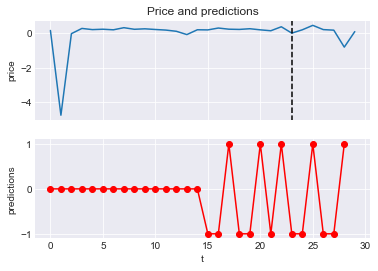

In [6]:
country = 'Germany'

df_to_predict = database_training_sv_standard[country].append(database_validation_sv_standard[country])
df_to_predict = df_to_predict.reset_index()
del df_to_predict['index']
n_forecast_validation = 6

N, p = df_to_predict.shape
size_time_series = N

env = Environment(n_epochs, window_size_observation, size_time_series, database_training_sv_standard)

env.set_list_of_games(df_to_predict)



agent.epsilon = 0

actions, empty_status, rewards = [], [], []

for i in range(1):
    score = 0
    done = False

    observation = env.reset()
    valid_actions = [0, 1]

    # take only signal as observation for now: 
    observation= np.squeeze(observation.values.transpose().reshape((1, -1)))
    
    while not done:
        action = agent.choose_action(observation, valid_actions)
        observation_, reward, done, valid_actions = env.step(action)


        # take only signal as observation for now: 
        observation_= np.squeeze(observation_.values.transpose().reshape((1, -1)))

        score += reward
        observation = observation_


        empty_status.append(env.get_status_emtpy())
        actions.append(action)
        rewards.append(reward)



    df = env.get_current_df()
    predictions = [get_prediction(action, empty_status) for action, empty in zip(actions, empty_status)]

    predictions = [0 for i in range(window_size_observation)] + predictions
    rewards = [0 for i in range(window_size_observation)] + rewards
    actions = [0 for i in range(window_size_observation)] + actions





fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)


ax.plot(df.iloc[:,0], label='price')
ax.axvline(x= len(df) - n_forecast_validation - 1, ymin=-100, ymax=500, color='black',linestyle='--', alpha=1)
ax.grid()
ax.set_ylabel('price') 
ax.set_title("Price and predictions")



ax2.plot(predictions, 'ro-')
ax2.set_xlabel('t') 
ax2.set_ylabel('predictions') 



plt.grid()
plt.show()

In [7]:
predictions[-n_forecast_validation:]

[-1, -1, 1, -1, -1, 1]

Calculating prediciton for every country:

In [9]:
y_forecast_GAO = {}


for country in database_training_sv_standard.keys():

    df_to_predict = database_training_sv_standard[country].append(database_validation_sv_standard[country])
    df_to_predict = df_to_predict.reset_index()
    del df_to_predict['index']
    n_forecast_validation = 6

    N, p = df_to_predict.shape
    size_time_series = N

    env = Environment(n_epochs, window_size_observation, size_time_series, database_training_sv_standard)

    env.set_list_of_games(df_to_predict)



    agent.epsilon = 0

    actions, empty_status, rewards = [], [], []

    for i in range(1):
        score = 0
        done = False

        observation = env.reset()
        valid_actions = [0, 1]

        # take only signal as observation for now: 
        observation= np.squeeze(observation.values.transpose().reshape((1, -1)))

        while not done:
            action = agent.choose_action(observation, valid_actions)
            observation_, reward, done, valid_actions = env.step(action)


            # take only signal as observation for now: 
            observation_= np.squeeze(observation_.values.transpose().reshape((1, -1)))

            score += reward
            observation = observation_


            empty_status.append(env.get_status_emtpy())
            actions.append(action)
            rewards.append(reward)



        df = env.get_current_df()
        predictions = [get_prediction(action, empty_status) for action, empty in zip(actions, empty_status)]

        predictions = [0 for i in range(window_size_observation)] + predictions
        rewards = [0 for i in range(window_size_observation)] + rewards
        actions = [0 for i in range(window_size_observation)] + actions


    y_forecast = predictions[-n_forecast_validation:]
    y_forecast_GAO[country] = y_forecast


    fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)


    ax.plot(df.iloc[:,0], label='price')
    ax.axvline(x= len(df) - n_forecast_validation - 1, ymin=-100, ymax=500, color='black',linestyle='--', alpha=1)
    ax.grid()
    ax.set_ylabel('price') 
    ax.set_title("Price and predictions")



    ax2.plot(predictions, 'ro-')
    ax2.set_xlabel('t') 
    ax2.set_ylabel('predictions') 



    plt.grid()



    wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project/plots_drl_gao'
    save_dir = os.path.join(wdir, country+'.png')

    plt.savefig(save_dir, dpi = 500, bbox_inches='tight')
    plt.close()
